In [503]:
pip list

Package                       Version        
----------------------------- ---------------
absl-py                       0.10.0         
alabaster                     0.7.12         
albumentations                0.1.12         
altair                        4.1.0          
argon2-cffi                   20.1.0         
asgiref                       3.3.0          
astor                         0.8.1          
astropy                       4.1            
astunparse                    1.6.3          
async-generator               1.10           
atari-py                      0.2.6          
atomicwrites                  1.4.0          
attrs                         20.2.0         
audioread                     2.1.9          
autograd                      1.3            
Babel                         2.8.0          
backcall                      0.2.0          
beautifulsoup4                4.6.3          
bleach                        3.2.1          
blis                          0.4.

In [504]:
# Imports
import numpy as np
import pandas as pd
from datetime import date
import re

In [505]:
# Load data
xl_file = pd.ExcelFile('https://github.com/Lambda-School-Labs/bridges-to-prosperity-ds-d/blob/main/Data/B2P%20Dataset_2020.10.xlsx?raw=true')
dfs = {sheet_name: xl_file.parse(sheet_name) for sheet_name in xl_file.sheet_names}
print(dfs.keys())
df = dfs['Data']

dict_keys(['Data', 'Data Dictionary', 'Contextual Summary'])


In [506]:
dfs['Data Dictionary']

Field               Description (if not self-explanatory)
0                                       Bridge Name                                                NaN
1                  Bridge Opportunity: Project Code                                          Unique ID
2              Bridge Opportunity: Needs Assessment  This will be populated with "Rwanda 2018 Needs...
3            Bridge Opportunity: Level 1 Government                                           Province
4            Bridge Opportunity: Level 2 Government                                           District
5                         Bridge Opportunity: Stage       Project status of this site as of 2020.10.26
6                Bridge Opportunity: GPS (Latitude)                                                NaN
7               Bridge Opportunity: GPS (Longitude)                                                NaN
8                   Bridge Opportunity: Bridge Type       Type of standard bridge built or recommended
9                      Bridge Opportunity: Span (m)  The length of the bridge as determined by seni...
10  Bridge Opportunity: Individuals Directly Served                                                NaN
11            Bridge Opportunity: Project Narrative                                                NaN
12                     Bridge Opportunity: Comments  This field contains the data from the 2013/201...
13                                  Form: Form Name  All data from this column on was a part of the...
14                                 Form: Created By  Assessor that conducted the project assessment...
15        Proposed Bridge Location (GPS) (Latitude)                   The initial proposed coordinates
16       Proposed Bridge Location (GPS) (Longitude)                   The initial proposed coordinates
17                          Current crossing method    Description of the community crossed pre-bridge
18               Nearest all-weather crossing point   Nearest place people can cross the river safely 
19                   Days per year river is flooded                                                NaN
20               Flood duration during rainy season                                                NaN
21                   Market access blocked by river                                                NaN
22                Education access blocked by river                                                NaN
23                   Health access blocked by river                                                NaN
24                    Other access blocked by river                                                NaN
25                              Primary occupations                                                NaN
26                              Primary crops grown                                                NaN
27            River crossing deaths in last 3 years                                                NaN
28          River crossing injuries in last 3 years                                                NaN
29                            Incident descriptions                                                NaN
30                      Notes on social information                                                NaN
31                             Cell service quality                                                NaN
32                                4WD Accessibility  How much of the year the path to the site is a...
33                             Name of nearest city                                                NaN
34             Name of nearest paved or sealed road                                                NaN
35                            Bridge classification  Assessor's estimate of whether a bridge at the...
36                               Flag for Rejection  Assessor's estimate of whether or not the brid...
37                                 Rejection Reason  Reason the site was flagged for rejection, if ...
38                          

In [507]:
dfs['Contextual Summary']

Problem 1: Parsing 2013/2014 needs assessment data into current fields 300+ sites were initially identified as part of an informal needs assessment conducted by our Rwanda field staff over 2013 and 2014. We collected much of the same data that we do now, but in a less structured format. When we created the database in 2017, we loaded all the old needs assessment into the general comments field on each bridge record (column L in this table), just to keep as a reference. We now believe that loading this data into our standard project assessments would be a benefit to future needs assessment work, both field-based and remote. We would love to see the needs assessment data from Column L parsed into the corresponding columns after it (M+), with a new row if there is existing data in those columns. If no corresponding column is obvious, we'd like to see new columns created for any extraneous data that is common to the old format. 
0  Problem 2: Predicting which sites will be tech...                      Any sites with a "Yes" in the column AQ have u...

### Problem 1: Parsing 2013/2014 needs assessment data into current fields:
300+ sites were initially identified as part of an informal needs assessment conducted by our Rwanda field staff over 2013 and 2014. We collected much of the same data that we do now, but in a less structured format. When we created the database in 2017, we loaded all the old needs assessment into the general comments field on each bridge record (column L in this table), just to keep as a reference. We now believe that loading this data into our standard project assessments would be a benefit to future needs assessment work, both field-based and remote. We would love to see the needs assessment data from Column L parsed into the corresponding columns after it (M+), with a new row if there is existing data in those columns. If no corresponding column is obvious, we'd like to see new columns created for any extraneous data that is common to the old format. 

### Problem 2: Predicting which sites will be technically rejected in future engineering reviews:
Any sites with a "Yes" in the column AQ have undergone a full technical review, and of those, the Stage (column L) can be considered to be correct. Any sites with a "Yes" in Column AQ have not undergone a full technical review, and the Stage is based on the assessor's initial estimate as to whether the site was technically feasible or not. We want to know if we can use the sites that have been reviewed to understand which of the sites that haven't yet been reviewed are likely to be rejected by the senior engineering team. **Any of the data can be used, but our guess is that Estimated Span, Height Differential Between Banks, Created By, and Flag for Rejection are likely to be the most reliable predictors. **

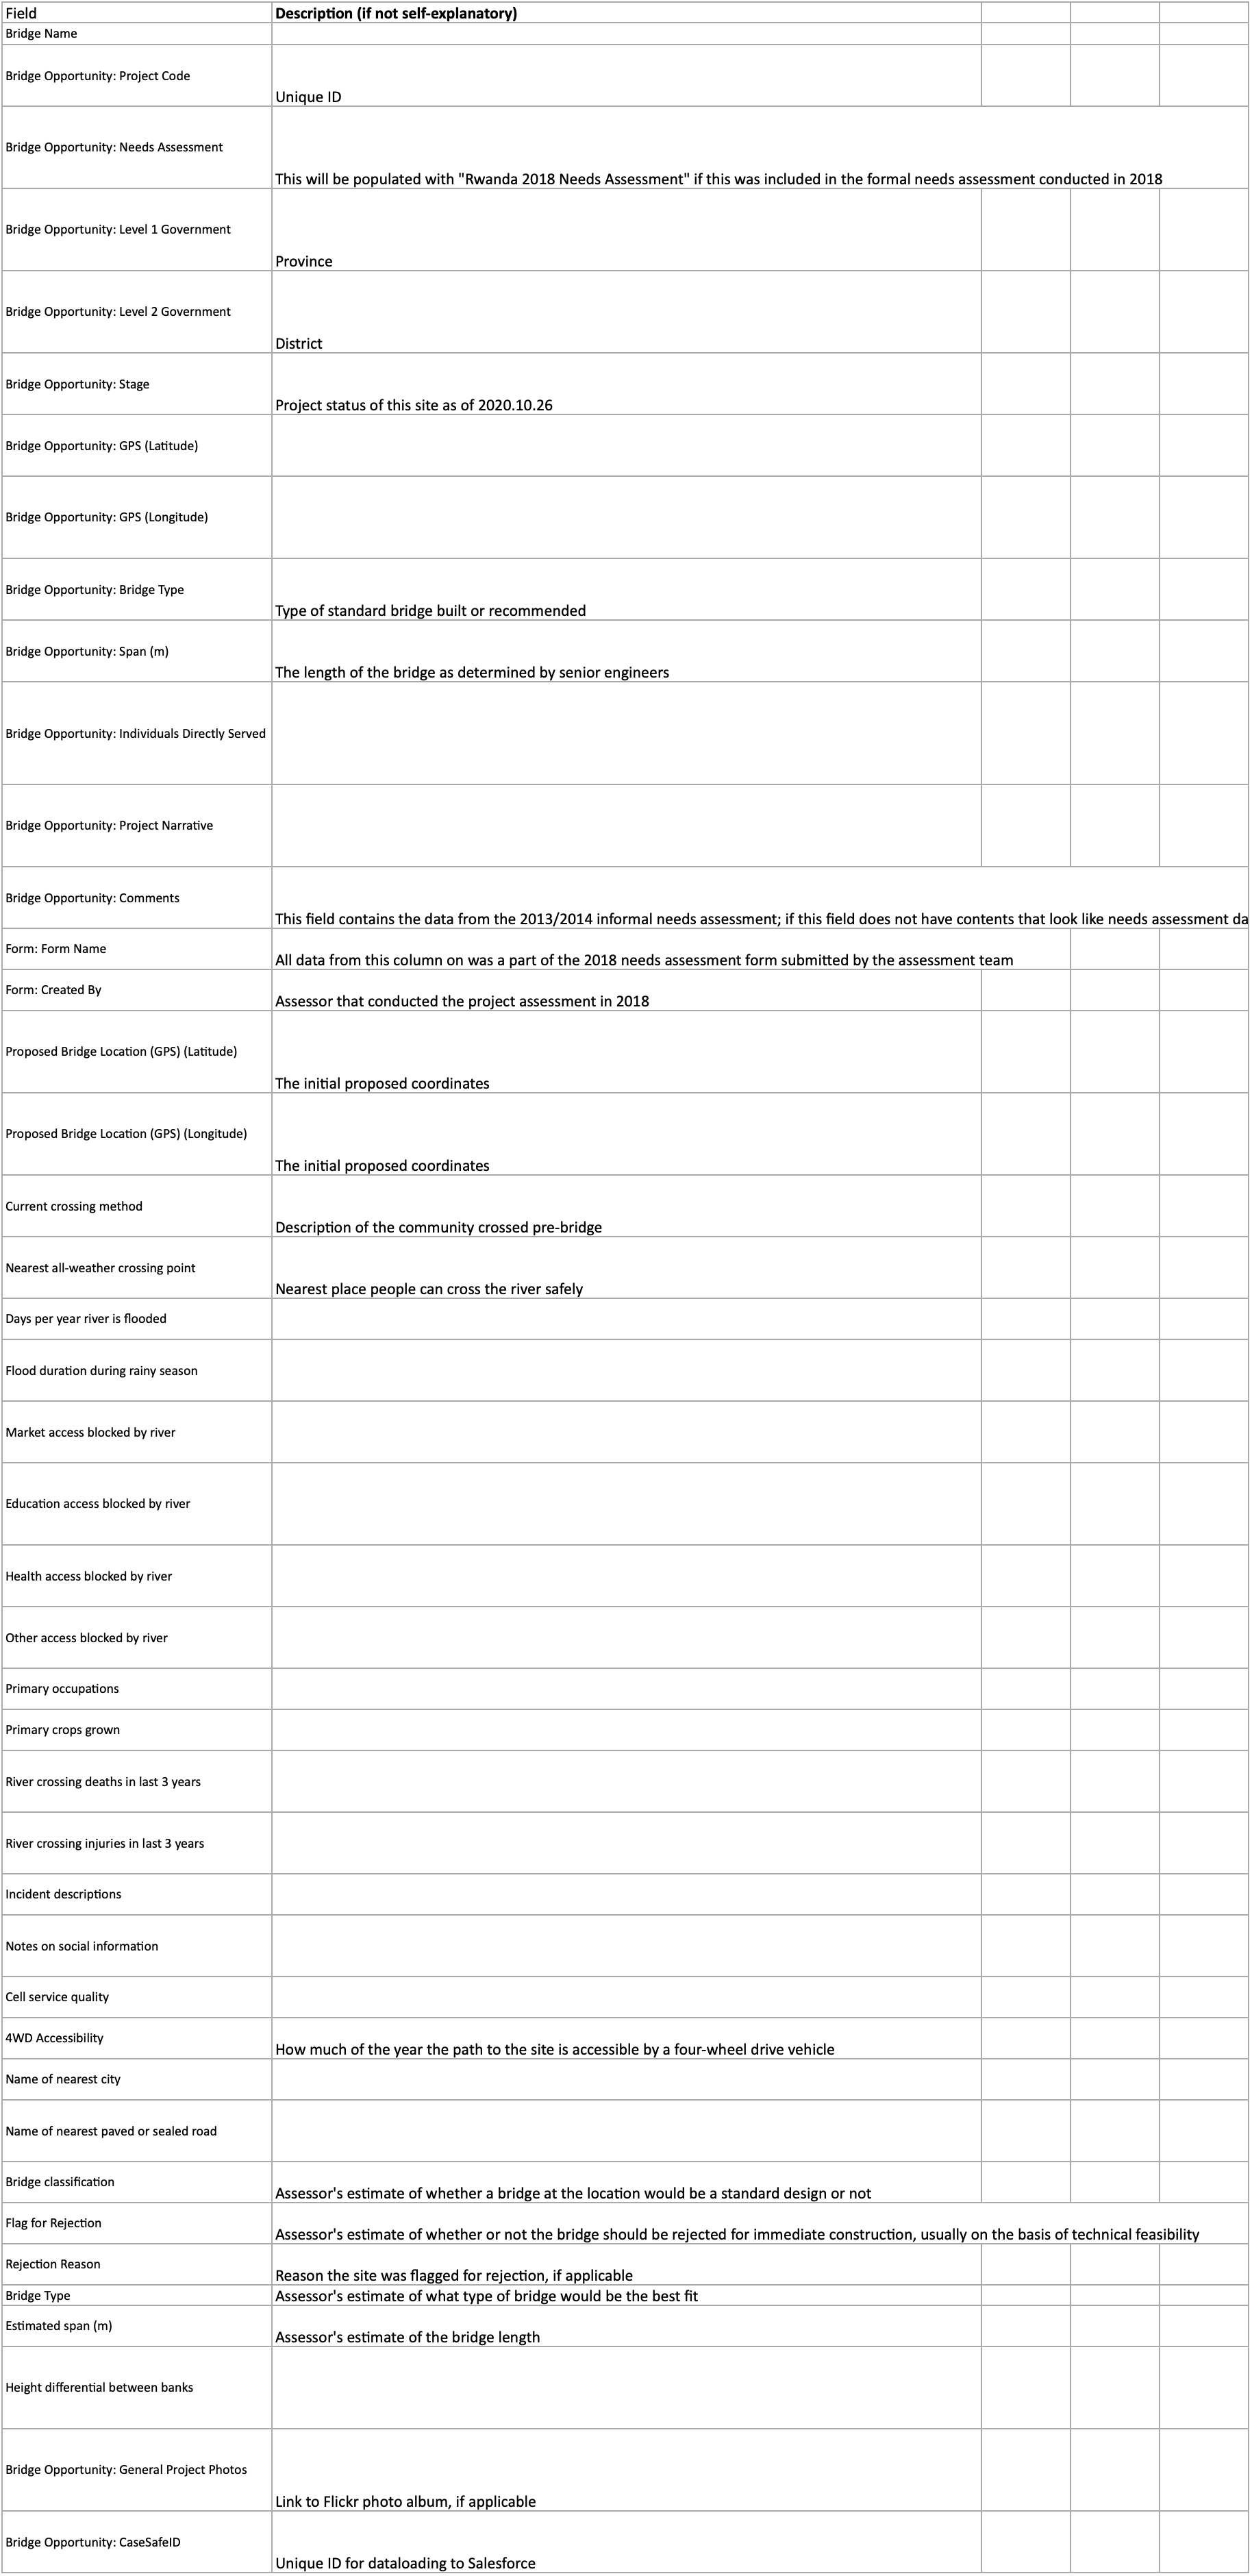

In [508]:
df[['Bridge Opportunity: Stage', 'Flag for Rejection', 'Rejection Reason', 'Senior Engineering Review Conducted']][(df['Senior Engineering Review Conducted'] == 'Yes') & (df['Flag for Rejection'] == 'Yes')]

Bridge Opportunity: Stage  ... Senior Engineering Review Conducted
0                   Cancelled  ...                                 Yes
5                    Complete  ...                                 Yes
354                  Rejected  ...                                 Yes
474                  Rejected  ...                                 Yes

[4 rows x 4 columns]

In [509]:
# stage is based on engineering review if any.
# flag for rejection is initial assessment
df[['Bridge Opportunity: Stage','Flag for Rejection']][df['Senior Engineering Review Conducted'] == 'Yes'].value_counts()

Bridge Opportunity: Stage  Flag for Rejection
Complete                   No                    27
Rejected                   No                    17
Prospecting                No                    16
Rejected                   Yes                    2
Confirmed                  No                     2
Complete                   Yes                    1
Cancelled                  Yes                    1
dtype: int64

In [510]:
df[['Bridge Opportunity: Stage','Flag for Rejection']][df['Senior Engineering Review Conducted'] != 'Yes'].value_counts()

Bridge Opportunity: Stage  Flag for Rejection
Rejected                   No                    778
                           Yes                   243
Identified                 No                    178
Under Construction         No                      6
Identified                 Yes                     1
dtype: int64

In [511]:
df.sample(3, random_state=42, axis=0)

Bridge Name  ... Senior Engineering Review Conducted
852   Ruhengeri 2  ...                                 NaN
184       Kabira1  ...                                 NaN
1261     Kinyinya  ...                                 NaN

[3 rows x 43 columns]

In [512]:
df.isnull().sum()

Bridge Name                                           0
Bridge Opportunity: Project Code                      0
Bridge Opportunity: Needs Assessment                 40
Bridge Opportunity: Level 1 Government                0
Bridge Opportunity: Level 2 Government                0
Bridge Opportunity: Stage                             0
Bridge Opportunity: GPS (Latitude)                   12
Bridge Opportunity: GPS (Longitude)                  12
Bridge Opportunity: Bridge Type                    1287
Bridge Opportunity: Span (m)                       1082
Bridge Opportunity: Individuals Directly Served       6
Bridge Opportunity: Comments                       1078
Form: Form Name                                       0
Form: Created By                                      0
Proposed Bridge Location (GPS) (Latitude)            40
Proposed Bridge Location (GPS) (Longitude)           40
Current crossing method                             160
Nearest all-weather crossing point              

**"Bridge Opportunity: Bridge Type", "Bridge Type"**

In [513]:
# Seems Suspended and Suspension are two different things
df['Bridge Type'].value_counts()

Suspension    648
Suspended     608
Other          46
Name: Bridge Type, dtype: int64

In [514]:
# change Suspended to Suspension
# df['Bridge Type'] = df['Bridge Type'].apply(lambda x: 'Suspension' if x == 'Suspended' else x)

**"Bridge Opportunity: Span (m)", "Estimated span (m)"**

* What is the difference between 'Estimated span (m)' and 'Bridge Opportunity: Span (m)'? The numbers do not go together. 

In [515]:
df['Bridge Opportunity: Span (m)'].value_counts()

10.0     24
35.0     18
40.0     16
45.0     14
50.0     13
         ..
38.0      1
112.0     1
104.0     1
850.0     1
54.0      1
Name: Bridge Opportunity: Span (m), Length: 110, dtype: int64

In [516]:
df['Estimated span (m)'].value_counts()

30.0    178
40.0     73
32.0     51
60.0     46
50.0     42
       ... 
41.2      1
53.4      1
55.4      1
38.4      1
56.2      1
Name: Estimated span (m), Length: 231, dtype: int64

In [517]:
df['Estimated span (m)'][df['Bridge Opportunity: Span (m)'] == 10.0]

69     55.0
77     40.0
79     37.0
306    47.4
313    54.4
316    44.0
321    39.0
331    31.0
336    60.0
337     NaN
370     NaN
372    66.0
386    53.0
393    37.0
394    49.0
400    40.0
406    60.0
410    56.5
418     NaN
422    38.0
423     NaN
442    88.4
471    90.0
472    64.0
Name: Estimated span (m), dtype: float64

** "Bridge Opportunity: GPS (Latitude)/Longtitue", "Proposed Bridge Location (GPS) (Latitude)"/Longtitude, **

In [518]:
df[["Proposed Bridge Location (GPS) (Latitude)", "Bridge Opportunity: GPS (Latitude)"]]

Proposed Bridge Location (GPS) (Latitude)  Bridge Opportunity: GPS (Latitude)
0                                     -2.760833                           -2.760833
1                                     -2.322534                           -2.322534
2                                           NaN                           -2.513333
3                                     -2.476407                           -2.476407
4                                     -2.233574                           -2.233022
...                                         ...                                 ...
1467                                  -2.049360                           -2.049360
1468                                  -2.209007                           -2.209275
1469                                  -2.147630                           -2.147630
1470                                  -2.133330                           -2.133330
1471                                  -2.117130                           -2.109525

[1472 rows x 2 columns]

In [519]:
# The proposed columns can be dropped
df[["Proposed Bridge Location (GPS) (Latitude)", "Bridge Opportunity: GPS (Latitude)"]][df["Bridge Opportunity: GPS (Latitude)"].isna()]

Proposed Bridge Location (GPS) (Latitude)  Bridge Opportunity: GPS (Latitude)
103                                         NaN                                 NaN
266                                         NaN                                 NaN
476                                         NaN                                 NaN
621                                         NaN                                 NaN
672                                         NaN                                 NaN
681                                         NaN                                 NaN
682                                         NaN                                 NaN
683                                         NaN                                 NaN
684                                         NaN                                 NaN
832                                         NaN                                 NaN
990                                         NaN                                 NaN
1087                                        NaN                                 NaN

In [520]:
# na_indx = df.index[df["Bridge Opportunity: GPS (Latitude)"].isna()]
# df["Bridge Opportunity: GPS (Latitude)"][na_indx] = df["Proposed Bridge Location (GPS) (Latitude)"][na_indx]
# df["Bridge Opportunity: GPS (Latitude)"].isna().sum()

**"Bridge Opportunity: Comments"**

In [521]:
# ~ The tilde operator negates the Boolean values in the DataFrame: True becomes False and False becomes True
df["Bridge Opportunity: Comments"][~df["Bridge Opportunity: Comments"].isna()]

0                   Steep slopes to deal with for anchors
2       Likely piloting steel decking on this bridge. ...
3       3000-6000 people directly served, Elevation:21...
4       Not Duplicate 500-1000 people directly served,...
5       Not Duplicate 3000-6000 people directly served...
                              ...                        
1323    ARK set stage as REJECTED due to an active ups...
1463    ARK - Rejecting bridge due to worsening upstre...
1465    500-1000 people directly served, Elevation:174...
1466    3000-6000 people directly served, Elevation:15...
1471    Was a duplicate site (specifically, an alterna...
Name: Bridge Opportunity: Comments, Length: 394, dtype: object

** "Form: Form Name" **

In [522]:
df["Form: Form Name"]

0       Project Assessment - 2018.10.10
1        Project Assessment - 2017.7.12
2        Project Assessment - 2018.7.27
3         Project Assessment - 2018.9.1
4         Project Assessment - 2018.9.4
                     ...               
1467     Project Assessment - 2018.8.25
1468    Project Assessment - 2018.10.28
1469    Project Assessment - 2018.10.28
1470    Project Assessment - 2018.10.28
1471    Project Assessment - 2018.10.14
Name: Form: Form Name, Length: 1472, dtype: object

** "Form: Created By" **

In [523]:
df["Form: Created By"]

0       aimablengirabakunzi taroworks
1                       Stephanie May
2          etiennemutebutsi taroworks
3       aimablengirabakunzi taroworks
4         dominiquehabimana taroworks
                    ...              
1467       edouardumwanzuro taroworks
1468    aimablengirabakunzi taroworks
1469       edouardumwanzuro taroworks
1470       edouardumwanzuro taroworks
1471       edouardumwanzuro taroworks
Name: Form: Created By, Length: 1472, dtype: object

** "Current crossing method" **

In [524]:
df["Current crossing method"].value_counts()

Timber                                         398
None                                           363
Timber bridge                                  181
Bridge in timber                               109
Timbers                                         57
                                              ... 
Wading/fording                                   1
Walk through the water                           1
Vehicular bridge                                 1
Stepping on stones                               1
People are using Timbers to cross the river      1
Name: Current crossing method, Length: 118, dtype: int64

In [525]:
df["Current crossing method"] = df["Current crossing method"].apply(lambda x: "Timber" if 
                                    x in ["Timbers", "One timber", "Bridge in timber ( One log only)", "Bridge in timber (One log)", "Old timber",
                                          "Timber logs", "Timber crossing", "Two timbers", "7 timbers", "Timbet", "People use timbers to cross the river"]
                                    else "Timber Bridge" if x in ["Bridge in timber", "Timber bridge", "timber bridge"]
                                    else "Concrete" if x == "Concrete bridge"
                                    else "Boat" if x in ["Boats", "Crossing by a boat"]
                                    else "disrepair" if type(x) == str and bool(re.match(r".*disrepair.*", x))
                                    else "Fording" if x in ["fording and sometimes one single tree", "Walking through the river"]
                                    else "None" if x in ["none", "Nine"]
                                    else x)

In [526]:
df["Current crossing method"].value_counts()

Timber                  486
None                    370
Timber Bridge           323
Boat                     20
disrepair                10
                       ... 
Stepping on stones        1
Six wood logs bridge      1
Log of timber.            1
Timbe                     1
Timber. Bridge            1
Name: Current crossing method, Length: 93, dtype: int64

** "Nearest all-weather crossing point" **

In [527]:
df["Nearest all-weather crossing point"][:10]

0                                                  NaN
1                                       2km downstream
2    Is located at 5km upstream. People pay 1000rwf...
3                                                 None
4                       Vehicular bridge, 5 kilometers
5                  vehicular is in two hours walk away
6                       Vehicular bridge in 45 minutes
7       RDF bridge within 40 minutes from yanza bridge
8                                                  6km
9    There is a vehicular bridge at Nyiragase , 3 h...
Name: Nearest all-weather crossing point, dtype: object

In [528]:
# column with multiple data types
df["Nearest all-weather crossing point"].apply(type).value_counts()

<class 'str'>      1287
<class 'float'>     184
<class 'int'>         1
Name: Nearest all-weather crossing point, dtype: int64

In [529]:
# make the entire column string
df["Nearest all-weather crossing point"] = df["Nearest all-weather crossing point"].apply(lambda x: str(x) if type(x) != str else x)

In [530]:
# Extract the quantities
mask = df["Nearest all-weather crossing point"].str.contains(r"([0-9.]+)(\s*)(?:(minutes)|(hours?)|(kilometers)|([kK]?[mM]))")
df["Nearest all-weather crossing point"][mask] = df["Nearest all-weather crossing point"][mask].str.replace(
    r'^([^0-9]*)([0-9.]+)(\s*)(?:(minutes)|(hours?)|(kilometers)|([kK]?[mM])).*$', r'\2 \4\5\6\7', regex=True)
df["Nearest all-weather crossing point"]
# .str.replace does this: Test if pattern or regex is contained within a string of a Series or Index.Return boolean Series 
# or Index based on whether a given pattern or regex is contained within a string of a Series

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


0                nan
1               2 km
2               5 km
3               None
4       5 kilometers
            ...     
1467        No point
1468           700 m
1469            None
1470            None
1471        No point
Name: Nearest all-weather crossing point, Length: 1472, dtype: object

** "river is flooded" **

In [531]:
df[["Days per year river is flooded", "Flood duration during rainy season"]]

Days per year river is flooded                 Flood duration during rainy season
0                                NaN                                                NaN
1                              120.0                                            12hours
2                               60.0                                               1day
3                               60.0  All time in April and May and it is rarely to ...
4                               35.0  April To May, September to December, 12 hours ...
...                              ...                                                ...
1467                            35.0                               Floods takes 7 hours
1468                            50.0  50times in April, May, October November and De...
1469                           280.0    5 days of flood , this kiraro is very dangerous
1470                           270.0                                     1 day of flood
1471                           240.0                                   4 hours of flood

[1472 rows x 2 columns]

** "access blocked by river" **

In [532]:
df[["Market access blocked by river", "Education access blocked by river", "Health access blocked by river", "Other access blocked by river"]]

Market access blocked by river  ...                      Other access blocked by river
0                                                   NaN  ...                                                NaN
1     Schools, hospital, markets and government serv...  ...                                                NaN
2        Markets,farms blocked by this river both sides  ...  Potable water, places of worship ,places for r...
3                                               Markets  ...                    Churches and Government offices
4     Birambo market, Gasura market, kirinda market(...  ...                                               None
...                                                 ...  ...                                                ...
1467                          Muhanga and Rutaka market  ...                            Muhanga district office
1468  Gahororo, Musongati, Kibingo villages don't ha...  ...                                        Cell office
1469  Rwankuba sector population don't have acess to...  ...  Mubuga sector ,twumba sector ,Gishyita sector ...
1470  Wingwa village & Kigogwe village &Karambo vill...  ...  Wingwa village & Kigogwe village &Karambo vill...
1471  Nyakabande village , kigabiro village , and Ny...  ...  Nyakabande village , kigabiro village , and Ny...

[1472 rows x 4 columns]

**Primary products**

In [533]:
df[["Primary occupations", "Primary crops grown"]]

Primary occupations                             Primary crops grown
0                                                  NaN                                             NaN
1                                              farming                                          banana
2                           Farming and small business                         Corns, banana and beans
3         Farming of large tea plantation, wheat farms      Tea, cow pea, wheat, beans, sweet potatoes
4                                              Farming  Cassava, maize, beans, sorghum, sweet potatoes
...                                                ...                                             ...
1467                                           Farming                               Potatoes , banana
1468  Farming of sweet potatoes, cassava, beans, maize           Sweet potatoes, beans, maize, cassava
1469                                           Farming                          Banana , beans , maize
1470                                           Farming                                Potatoes, banana
1471                                           Farming                     Banana , potatoes , Cassava

[1472 rows x 2 columns]

In [534]:
df["Primary occupations"].value_counts()

Farming                                                                                             451
Agriculture                                                                                         161
Agriculture and animal husbandry                                                                     28
Firming                                                                                              21
School, Market, farms                                                                                 8
                                                                                                   ... 
School, health center and Hospital, Market, ...                                                       1
Rurembo and Mubayu market traders, farmers on small scale of the sweet potatoes, maize and wheat      1
AGRICULTURE AND ANIMAL KEEPING                                                                        1
Coffee Farmers, and workers of kaziba coffee factor             

In [535]:
df["Primary occupations"].apply(type).value_counts()

<class 'str'>      1260
<class 'float'>     212
Name: Primary occupations, dtype: int64

In [536]:
df["Primary occupations"].replace({"Firming": "Farming",
                                   "Farmers": "Farming",
                                   "School, Market, farms": "School, Market, Farms",
                                   "Market, school, farms,": "School, Market, Farms",
                                   "School, Market, farms,": "School, Market, Farms",
                                   "Farms, school, market": "School, Market, Farms",
                                   "School, farms, market": "School, Market, Farms",
                                   "Market, farms, schools": "School, Market, Farms",
                                   "School, farms, Market": "School, Market, Farms",
                                   "School, Market, farm": "School, Market, Farms",
                                   "School, farms, Market,": "School, Market, Farms",
                                   "School, Market and farms": "School, Market, Farms",
                                   "School, farms and market": "School, Market, Farms",
                                   "Market, schools, farms": "School, Market, Farms",

                                   "Market and farms": "Market and Farms",
                                   "Market, farms,": "Market and Farms",
                                   "Farming and marketing": "Market and Farms",
                                   }, inplace=True)
df["Primary occupations"].value_counts()[:20]

Farming                                              476
Agriculture                                          161
School, Market, Farms                                 40
Agriculture and animal husbandry                      28
Market and Farms                                       9
Farming and business                                   8
Agriculture and Brick making                           7
Farming and livestock                                  4
Tea farming and Animal keeping                         4
Farming of sweet potatoes, banana, cassava             3
School, Market,                                        3
commerce, agriculture and Human-Powered Transport      3
Farming of sweet potatoes, banana, beans               3
Farmers on both side and traders                       2
Farms, Market, school                                  2
Farming of sweet potatoes, beans, maize                2
Market, health center, farms                           2
Farming of sweet potatoes, cass

In [537]:
df["Primary crops grown"]

0                                                  NaN
1                                               banana
2                              Corns, banana and beans
3           Tea, cow pea, wheat, beans, sweet potatoes
4       Cassava, maize, beans, sorghum, sweet potatoes
                             ...                      
1467                                 Potatoes , banana
1468             Sweet potatoes, beans, maize, cassava
1469                            Banana , beans , maize
1470                                  Potatoes, banana
1471                       Banana , potatoes , Cassava
Name: Primary crops grown, Length: 1472, dtype: object

In [538]:
df["Primary crops grown"].unique().shape

(808,)

In [539]:
# re-arrange the values to reduce the value count
# Tokenize the strings, lower case, make singular
print(f'unique count before cleaning: {df["Primary crops grown"].unique().shape[0]}')
df["Primary crops grown"].fillna("", inplace=True)
df["Primary crops grown"] = df["Primary crops grown"].apply(
    lambda x: x.lower() if type(x)==str else x).apply(
        lambda x: [word.strip()[:re.search("(e?s?)$", word.strip()).start()] for word in x.replace("and", ",").split(',')])

df["Primary crops grown"] = df["Primary crops grown"].apply(lambda x: ", ".join(sorted(x)))

print(f'unique count after cleaning: {df["Primary crops grown"].unique().shape[0]}')
df["Primary crops grown"]

unique count before cleaning: 808
unique count after cleaning: 512


0                                                 
1                                           banana
2                               banana, bean, corn
3          bean, cow pea, sweet potato, tea, wheat
4       bean, cassava, maiz, sorghum, sweet potato
                           ...                    
1467                                banana, potato
1468             bean, cassava, maiz, sweet potato
1469                            banana, bean, maiz
1470                                banana, potato
1471                       banana, cassava, potato
Name: Primary crops grown, Length: 1472, dtype: object

** River crossing injuries/death in last 3 years **

In [540]:
# drop 'Incident descriptions' and 'Notes on social information',
df[["River crossing deaths in last 3 years","River crossing injuries in last 3 years", "Incident descriptions", "Notes on social information"]]

River crossing deaths in last 3 years  ...                        Notes on social information
0                                       NaN  ...                                                NaN
1                                       2.0  ...  Most of the facilities locate at the left side...
2                                       3.0  ...  5 cells (kabuye,gasumba,kanyinya, buremera and...
3                                       0.0  ...  Market 1( Minaga, Gishwati, Mujerenge, Gikungu...
4                                       4.0  ...  The population information of all adjacent com...
...                                     ...  ...                                                ...
1467                                    0.0  ...  Rutaka( Cyurutare village ), Mata health cente...
1468                                    0.0  ...  The social survey information were given by th...
1469                                   20.0  ...  Rubumba cell leader provided all info about in...
1470                                    1.0  ...  Gasharu village provided info about directly i...
1471                                    6.0  ...  Nyakabande village leader gave info about dire...

[1472 rows x 4 columns]

In [541]:
df[["Cell service quality", "4WD Accessibility", "Name of nearest city", "Name of nearest paved or sealed road"]]

Cell service quality  ... Name of nearest paved or sealed road
0                     NaN  ...                                  NaN
1                    Fair  ...                   Karongi-Nyamasheke
2                    Good  ...                       Huye-Nyamagabe
3                    Fair  ...                     Nyamagabe-Rusizi
4                    Good  ...                            Nyamagabe
...                   ...  ...                                  ...
1467                 Fair  ...                    Ngororero-Muhanga
1468                 Good  ...                       Karongi-Rusizi
1469                 Good  ...                     Karongi- Muhanga
1470                 Fair  ...                     Karongi- Muhanga
1471                 Good  ...                     Karongi - Rusizi

[1472 rows x 4 columns]

In [542]:
print(df["Cell service quality"].unique())
print(df["4WD Accessibility"].unique())

[nan 'Fair' 'Good' 'Nonexistent']
[nan 'Seasonally' 'Never' 'Year Round']


In [543]:
df["Name of nearest city"].value_counts()

Huye         216
Musanze      148
Kigali       130
Karongi      117
Rusizi        87
            ... 
Nhakabuye      1
Karongo        1
Dubai          1
Congo-nil      1
RUGERERO       1
Name: Name of nearest city, Length: 96, dtype: int64

In [544]:
df["Name of nearest paved or sealed road"].value_counts()

NR1 (Kigali-Huye-Akanyaru)        77
Nyamagabe-Rusizi                  57
Kigali-musanze                    51
Karongi-Rusizi                    44
Rubavu-Rubengera                  42
                                  ..
Muhanga- Ngororero                 1
Kigali~musanze                     1
Kigali-Musanze (National Road)     1
Ngororero-Muhanga                  1
Kigali-Ndera                       1
Name: Name of nearest paved or sealed road, Length: 293, dtype: int64

In [545]:
df["Bridge classification"].value_counts(dropna=False)

Standard                                1239
NaN                                      177
Requires additional engineering           36
Outside of current engineering scope      20
Name: Bridge classification, dtype: int64

In [546]:
df["Flag for Rejection"].value_counts(dropna=False)

No     1024
Yes     248
NaN     200
Name: Flag for Rejection, dtype: int64

In [547]:
# Height differential between banks                   965
# Bridge Opportunity: General Project Photos         1426
# Bridge Opportunity: CaseSafeID                        0
# Senior Engineering Review Conducted 

In [548]:
df["Height differential between banks"].value_counts(dropna=False)

NaN      965
0.20      76
0.00      48
0.30      40
0.50      31
0.70      30
0.10      29
0.40      28
0.80      20
0.90      17
1.00      17
0.60      17
1.70      15
1.10      15
1.50      13
1.30      10
2.10       8
2.30       8
1.40       8
1.60       8
1.20       7
1.80       5
3.90       5
2.50       4
3.30       4
2.70       4
1.90       3
5.50       3
2.60       3
2.40       3
3.40       2
3.10       2
4.50       2
2.90       2
2.00       2
4.90       2
5.70       2
7.30       1
4.30       1
5.80       1
3.00       1
1.59       1
56.00      1
3.20       1
4.40       1
4.00       1
4.70       1
5.30       1
4.80       1
2.80       1
2.20       1
Name: Height differential between banks, dtype: int64

In [549]:
# seems to be a typo for 56m
df["Height differential between banks"] = df["Height differential between banks"].replace(to_replace=56.00, value=5.60)

In [550]:
df["Bridge Opportunity: CaseSafeID"]

0       006f100000asFErAAM
1       006f100000a82QzAAI
2       006f100000a86DaAAI
3       006f100000a86F4AAI
4       006f100000a86FXAAY
               ...        
1467    006f100000d6wBoAAI
1468    006f100000d1fMsAAI
1469    006f100000d1fPrAAI
1470    006f100000d1fTFAAY
1471    006f100000fHAHXAA4
Name: Bridge Opportunity: CaseSafeID, Length: 1472, dtype: object

In [551]:
df["Senior Engineering Review Conducted"].value_counts(dropna=False)

NaN    1383
Yes      89
Name: Senior Engineering Review Conducted, dtype: int64

In [552]:
print(df.shape)
df.dtypes

(1472, 43)


Bridge Name                                         object
Bridge Opportunity: Project Code                    object
Bridge Opportunity: Needs Assessment                object
Bridge Opportunity: Level 1 Government              object
Bridge Opportunity: Level 2 Government              object
Bridge Opportunity: Stage                           object
Bridge Opportunity: GPS (Latitude)                 float64
Bridge Opportunity: GPS (Longitude)                float64
Bridge Opportunity: Bridge Type                     object
Bridge Opportunity: Span (m)                       float64
Bridge Opportunity: Individuals Directly Served    float64
Bridge Opportunity: Comments                        object
Form: Form Name                                     object
Form: Created By                                    object
Proposed Bridge Location (GPS) (Latitude)          float64
Proposed Bridge Location (GPS) (Longitude)         float64
Current crossing method                             obje

In [553]:
df.head()

Bridge Name  ... Senior Engineering Review Conducted
0              Bukinga  ...                                 Yes
1             Kagarama  ...                                 Yes
2              Karambi  ...                                 Yes
3               Rugeti  ...                                 Yes
4  Nyakabuye - Nkomane  ...                                 Yes

[5 rows x 43 columns]

In [554]:
df['Flag for Rejection']

0       Yes
1       NaN
2       NaN
3        No
4        No
       ... 
1467     No
1468     No
1469     No
1470     No
1471     No
Name: Flag for Rejection, Length: 1472, dtype: object

In [555]:
df[df['Bridge Opportunity: Project Code'].str.match('[a-zA-Z]') == True]
# df['Bridge Opportunity: Project Code'] = df['Bridge Opportunity: Project Code'].astype(int)

Bridge Name  ... Senior Engineering Review Conducted
42       Gasura  ...                                 Yes
43  Kucyaruseke  ...                                 Yes

[2 rows x 43 columns]

# Download Cleaned Data Set

In [556]:
# from google.colab import files
# # cleaned_dataset = df.copy()
# df.to_csv("cleaned_dataset.csv", index = False)
# files.download('cleaned_dataset.csv')

## **Renaming Columns**

In [557]:
df.columns

Index(['Bridge Name', 'Bridge Opportunity: Project Code',
       'Bridge Opportunity: Needs Assessment',
       'Bridge Opportunity: Level 1 Government',
       'Bridge Opportunity: Level 2 Government', 'Bridge Opportunity: Stage',
       'Bridge Opportunity: GPS (Latitude)',
       'Bridge Opportunity: GPS (Longitude)',
       'Bridge Opportunity: Bridge Type', 'Bridge Opportunity: Span (m)',
       'Bridge Opportunity: Individuals Directly Served',
       'Bridge Opportunity: Comments', 'Form: Form Name', 'Form: Created By',
       'Proposed Bridge Location (GPS) (Latitude)',
       'Proposed Bridge Location (GPS) (Longitude)', 'Current crossing method',
       'Nearest all-weather crossing point', 'Days per year river is flooded',
       'Flood duration during rainy season', 'Market access blocked by river',
       'Education access blocked by river', 'Health access blocked by river',
       'Other access blocked by river', 'Primary occupations',
       'Primary crops grown', 'River

In [558]:
df = df.rename(columns={'Bridge Name': 'bridge_name',
                        'Bridge Opportunity: Project Code': 'bridge_opportunity_project_code',
                        'Bridge Opportunity: Needs Assessment': 'bridge_opportunity_needs_assessment',
                        'Bridge Opportunity: Level 1 Government': 'bridge_opportunity_level1_government',
                        'Bridge Opportunity: Level 2 Government': 'bridge_opportunity_level2_government',
                        'Bridge Opportunity: Stage': 'bridge_opportunity_stage',
                        'Bridge Opportunity: GPS (Latitude)': 'bridge_opportunity_gps_latitude',
                        'Bridge Opportunity: GPS (Longitude)': 'bridge_opportunity_gps_longitude',
                        'Bridge Opportunity: Bridge Type': 'bridge_opportunity_bridge_type', 
                        'Bridge Opportunity: Span (m)': 'bridge_opportunity_span_m',
                        'Bridge Opportunity: Individuals Directly Served': 'bridge_opportunity_individuals_directly_served',
                        'Bridge Opportunity: Comments': 'bridge_opportunity_comments', 
                        'Form: Form Name': 'form_form_name', 
                        'Form: Created By': 'form_created_by',
                        'Proposed Bridge Location (GPS) (Latitude)': 'proposed_bridge_location_gps_latitude',
                        'Proposed Bridge Location (GPS) (Longitude)': 'proposed_bridge_location_gps_longitude', 
                        'Current crossing method': 'current_crossing_method',
                        'Nearest all-weather crossing point': 'nearest_all_weather_crossing_point', 
                        'Days per year river is flooded': 'days_per_year_river_is_flooded',
                        'Flood duration during rainy season': 'flood_duration_during_rainy_season', 
                        'Market access blocked by river': 'market_access_blocked_by_river',
                        'Education access blocked by river': 'education_access_blocked_by_river', 
                        'Health access blocked by river': 'health_access_blocked_by_river',
                        'Other access blocked by river': 'other_access_blocked_by_river', 
                        'Primary occupations': 'primary_occupations',
                        'Primary crops grown': 'primary_crops_grown', 
                        'River crossing deaths in last 3 years': 'river_crossing_deaths_in_last_3_years',
                        'River crossing injuries in last 3 years': 'river_crossing_injuries_in_last_3_years', 
                        'Incident descriptions': 'incident_descriptions',
                        'Notes on social information': 'notes_on_social_information', 
                        'Cell service quality': 'cell_service_quality',
                        '4WD Accessibility': 'four_wd _accessibility', 
                        'Name of nearest city': 'name_of_nearest_city',
                        'Name of nearest paved or sealed road': 'name_of_nearest_paved_or_sealed_road', 
                        'Bridge classification':'bridge_classification',
                        'Flag for Rejection': 'flag_for_rejection', 
                        'Rejection Reason': 'rejection_reason', 
                        'Bridge Type': 'bridge_type',
                        'Estimated span (m)': 'estimated_span_m', 
                        'Height differential between banks': 'height_differential_between_banks',
                        'Bridge Opportunity: General Project Photos': 'bridge_opportunity_general_project_photos',
                        'Bridge Opportunity: CaseSafeID': 'bridge_opportunity_casesafeid',
                        'Senior Engineering Review Conducted': 'senior_engineering_review_conducted'})

In [559]:
df.columns

Index(['bridge_name', 'bridge_opportunity_project_code',
       'bridge_opportunity_needs_assessment',
       'bridge_opportunity_level1_government',
       'bridge_opportunity_level2_government', 'bridge_opportunity_stage',
       'bridge_opportunity_gps_latitude', 'bridge_opportunity_gps_longitude',
       'bridge_opportunity_bridge_type', 'bridge_opportunity_span_m',
       'bridge_opportunity_individuals_directly_served',
       'bridge_opportunity_comments', 'form_form_name', 'form_created_by',
       'proposed_bridge_location_gps_latitude',
       'proposed_bridge_location_gps_longitude', 'current_crossing_method',
       'nearest_all_weather_crossing_point', 'days_per_year_river_is_flooded',
       'flood_duration_during_rainy_season', 'market_access_blocked_by_river',
       'education_access_blocked_by_river', 'health_access_blocked_by_river',
       'other_access_blocked_by_river', 'primary_occupations',
       'primary_crops_grown', 'river_crossing_deaths_in_last_3_years',
 

In [560]:
df["bridge_opportunity_bridge_type"].value_counts()

Suspended Bridge       102
Suspension Bridge       78
Other                    3
Simple Span Bridge       1
Concrete (11 - 20m)      1
Name: bridge_opportunity_bridge_type, dtype: int64

In [561]:
df['flag_for_rejection'].value_counts()

No     1024
Yes     248
Name: flag_for_rejection, dtype: int64

In [562]:
df["bridge_opportunity_stage"].value_counts()

Rejected              1175
Identified             224
Complete                43
Prospecting             18
Under Construction       7
Confirmed                4
Cancelled                1
Name: bridge_opportunity_stage, dtype: int64

### **Identifying Target label**

In [563]:
df['bridge_opportunity_stage'].value_counts()

Rejected              1175
Identified             224
Complete                43
Prospecting             18
Under Construction       7
Confirmed                4
Cancelled                1
Name: bridge_opportunity_stage, dtype: int64

In [564]:
df['bridge_opportunity_stage'][df['senior_engineering_review_conducted']=='Yes'].value_counts()

Complete       43
Rejected       23
Prospecting    18
Confirmed       4
Cancelled       1
Name: bridge_opportunity_stage, dtype: int64

In [565]:
df['senior_engineering_review_conducted'].value_counts(dropna=False)

NaN    1383
Yes      89
Name: senior_engineering_review_conducted, dtype: int64

In [566]:
df['flag_for_rejection'].value_counts()

No     1024
Yes     248
Name: flag_for_rejection, dtype: int64

In [567]:
# Split the dataset:
# Positives:
positive = (
    (df['senior_engineering_review_conducted']=='Yes') & 
    (df['bridge_opportunity_stage'].isin(
        ['Complete', 'Prospecting', 'Confirmed', 'Under Construction']))
)

# Negatives:
negative = (
    (df['senior_engineering_review_conducted']=='Yes') & 
    (df['bridge_opportunity_stage'].isin(['Rejected', 'Cancelled']))
)


# # Potentially_Rejected_Bridges by Engineer:
# PR = (df['senior_engineering_review_conducted'].isna() & (df['flag_for_rejection'] == "Yes"))
# # Potentially Accepted_Bridged by Engineer:
# PA = (df['senior_engineering_review_conducted'].isna() & (df['flag_for_rejection'] == "No"))

In [568]:
# We are assigning all these to unknow
#drop rows where bridge opportunity stage still under construction
df = df[(df.bridge_opportunity_stage != 'Identified') & (df.bridge_opportunity_stage != "Under Construction")]
df['bridge_opportunity_stage'][df['senior_engineering_review_conducted'].isna()].value_counts()

Rejected    1152
Name: bridge_opportunity_stage, dtype: int64

In [569]:
# Create a new column named "Good Site." This is the target to predict.
# Assign a 1 for the positive class, 0 for the negative class and -1 for unkown class.
# Good sites who are labeled 1 are assumed to be locations where the engineer is assumed to 
# Assume the unkowns are also going to be rejected by Technical Engineer in the Future
df.loc[positive, 'good_site'] = 1
df.loc[negative, 'good_site'] = 0

#Treating Unknonws as rejections/acceptances Based on Flag for Rejection # assessor's initial estimate

# df.loc[PR, 'good_site'] = 0
# df.loc[PA, 'good_site'] = 1
df.good_site.value_counts()

1.0    65
0.0    24
Name: good_site, dtype: int64

In [570]:
df.dropna(subset = ["good_site"], inplace=True)

In [571]:
df.head()

bridge_name  ... good_site
0              Bukinga  ...       0.0
1             Kagarama  ...       1.0
2              Karambi  ...       1.0
3               Rugeti  ...       1.0
4  Nyakabuye - Nkomane  ...       1.0

[5 rows x 44 columns]

In [572]:
df['bridge_opportunity_bridge_type'].value_counts()

Suspended Bridge     37
Suspension Bridge    24
Other                 1
Name: bridge_opportunity_bridge_type, dtype: int64

In [573]:
df = df.replace({'bridge_opportunity_bridge_type': {"Suspended Bridge": "Suspended","Suspension Bridge":"Suspended"}})

In [574]:
df

bridge_name  ... good_site
0                 Bukinga  ...       0.0
1                Kagarama  ...       1.0
2                 Karambi  ...       1.0
3                  Rugeti  ...       1.0
4     Nyakabuye - Nkomane  ...       1.0
...                   ...  ...       ...
1105             Karutare  ...       0.0
1196           Nyabirondo  ...       0.0
1197               Mpanga  ...       0.0
1200             Karukina  ...       0.0
1249       Kabuga (Fukwe)  ...       0.0

[89 rows x 44 columns]

In [575]:
!pip install category_encoders

#**Handling Imbalance Data W/ SMOTE**

In [576]:
import category_encoders as ce
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.semi_supervised import LabelSpreading
le = preprocessing.LabelEncoder()
one_hot_encode  = ce.OneHotEncoder(use_cat_names=True)
ordinal_encode = OrdinalEncoder()

In [577]:
# Perform a Train ValidatioN Split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.impute import SimpleImputer

#bridge_classification,--- notincluding it as I don't see a real purpose for it
#Separate input features (X) and target variable (y)
keep_list = ['bridge_opportunity_span_m', 'days_per_year_river_is_flooded',
             'bridge_opportunity_bridge_type','height_differential_between_banks']

y = df.good_site
X = df[keep_list]
X.head()

bridge_opportunity_span_m  ...  height_differential_between_banks
0                        NaN  ...                                NaN
1                       48.0  ...                                0.7
2                       50.0  ...                                1.0
3                       68.0  ...                                1.1
4                       78.0  ...                                1.1

[5 rows x 4 columns]

In [578]:
X = pd.concat([one_hot_encode.fit_transform(X.bridge_opportunity_bridge_type),X], axis=1)
X = X.drop('bridge_opportunity_bridge_type',axis = 1)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [579]:
X.head()

bridge_opportunity_bridge_type_Suspended  ...  height_differential_between_banks
0                                         1  ...                                NaN
1                                         1  ...                                0.7
2                                         1  ...                                1.0
3                                         1  ...                                1.1
4                                         1  ...                                1.1

[5 rows x 6 columns]

In [580]:
X = X.drop('bridge_opportunity_bridge_type_nan',axis=1)

In [581]:
len(X)

89

In [582]:
X

bridge_opportunity_bridge_type_Suspended  ...  height_differential_between_banks
0                                            1  ...                                NaN
1                                            1  ...                                0.7
2                                            1  ...                                1.0
3                                            1  ...                                1.1
4                                            1  ...                                1.1
...                                        ...  ...                                ...
1105                                         0  ...                                2.3
1196                                         0  ...                                NaN
1197                                         0  ...                                NaN
1200                                         0  ...                                NaN
1249                                         0  ...                                1.1

[89 rows x 5 columns]

In [583]:
X.fillna(df.mean(), inplace=True)

In [584]:
X.isnull().sum(axis = 0)

bridge_opportunity_bridge_type_Suspended    0
bridge_opportunity_bridge_type_Other        0
bridge_opportunity_span_m                   0
days_per_year_river_is_flooded              0
height_differential_between_banks           0
dtype: int64

In [585]:
X

bridge_opportunity_bridge_type_Suspended  ...  height_differential_between_banks
0                                            1  ...                           0.863636
1                                            1  ...                           0.700000
2                                            1  ...                           1.000000
3                                            1  ...                           1.100000
4                                            1  ...                           1.100000
...                                        ...  ...                                ...
1105                                         0  ...                           2.300000
1196                                         0  ...                           0.863636
1197                                         0  ...                           0.863636
1200                                         0  ...                           0.863636
1249                                         0  ...                           1.100000

[89 rows x 5 columns]

In [586]:
y.isnull().sum(axis = 0)

0

In [587]:
# split into 70:30 ration 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42) 

# describes info about train and test set 
print("X_train dataset: ", X_train.shape) 
print("y_train dataset: ", y_train.shape) 
print("X_test dataset: ", X_test.shape) 
print("y_test dataset: ", y_test.shape) 

X_train dataset:  (62, 5)
y_train dataset:  (62,)
X_test dataset:  (27, 5)
y_test dataset:  (27,)


# **LabelSpreading model for semi-supervised learning**

In [588]:
pipe_model = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='median'),
    StandardScaler(),
    LabelSpreading(kernel='knn', n_neighbors=5)
)

In [589]:
# Fit
pipe_model.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('labelspreading',
                 LabelSpreading(alpha=0.2, gamma=20, kernel='knn', max_iter=30,
                                n_jobs=None, n_neighbors=5, tol=0.001))],
         verbose=False)

In [590]:
pipe_model.score(X_test,y_test)

0.8518518518518519

In [591]:
predictions = pipe_model.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67         6
         1.0       0.90      0.90      0.90        21

    accuracy                           0.85        27
   macro avg       0.79      0.79      0.79        27
weighted avg       0.85      0.85      0.85        27



In [592]:
print("Before OverSampling, label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, label '0': {} \n".format(sum(y_train == 0))) 

# import SMOTE module from imblearn library 
# pip install imblearn (if you don't have imblearn in your system) 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel()) 

print('After OverSampling, shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, shape of train_y: {} \n'.format(y_train_res.shape)) 

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 


Before OverSampling, label '1': 44
Before OverSampling, label '0': 18 

After OverSampling, shape of train_X: (88, 5)
After OverSampling, shape of train_y: (88,) 

After OverSampling, counts of label '1': 44
After OverSampling, counts of label '0': 44


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [593]:
pipe_model1 = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    LabelSpreading(kernel='knn', n_neighbors=5)
)

In [594]:
pipe_model1.fit(X_train_res,y_train_res)

Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('labelspreading',
                 LabelSpreading(alpha=0.2, gamma=20, kernel='knn', max_iter=30,
                                n_jobs=None, n_neighbors=5, tol=0.001))],
         verbose=False)

In [595]:
pipe_model1.score(X_test,y_test)

0.8518518518518519

In [596]:
pipe_model1.fit(X_train_res, y_train_res.ravel()) 


Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('labelspreading',
                 LabelSpreading(alpha=0.2, gamma=20, kernel='knn', max_iter=30,
                                n_jobs=None, n_neighbors=5, tol=0.001))],
         verbose=False)

In [597]:
# print classification report 
predictions = pipe_model1.predict(X_test)
print(classification_report(y_test, predictions)) 

              precision    recall  f1-score   support

         0.0       0.62      0.83      0.71         6
         1.0       0.95      0.86      0.90        21

    accuracy                           0.85        27
   macro avg       0.79      0.85      0.81        27
weighted avg       0.88      0.85      0.86        27



# **RandomForest Model W/ Cross Validation**

In [598]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import KFold
from sklearn import metrics

In [599]:
pipe_RFC = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestClassifier()
)

In [600]:
pipe_RFC.fit(X_train_res, y_train_res.ravel())

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=[], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, w...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        m

In [601]:
pipe_RFC.score(X_test,y_test)

0.8518518518518519

In [602]:
cv_accuracy_scores_rfc = cross_val_score(pipe_RFC, X_train_res, y_train_res, cv=20,scoring='accuracy')
print(cv_accuracy_scores_rfc)


/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: Future

[1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.5  1.
 1.   1.   0.75 1.   1.   1.  ]


In [603]:
print(f'Average Kfold Validation Score: {np.mean(cv_accuracy_scores_rfc)}')

Average Kfold Validation Score: 0.9625


In [604]:
# print classification report 
predictions = pipe_RFC.predict(X_test)
print(classification_report(y_test, predictions)) 

              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67         6
         1.0       0.90      0.90      0.90        21

    accuracy                           0.85        27
   macro avg       0.79      0.79      0.79        27
weighted avg       0.85      0.85      0.85        27



# **Logistic Regression Model w/ Near Miss Algorithim**


In [605]:
print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before Undersampling, counts of label '0': {} \n".format(sum(y_train == 0))) 

# apply near miss 
from imblearn.under_sampling import NearMiss 
nr = NearMiss() 

X_train_miss, y_train_miss = nr.fit_sample(X_train, y_train.ravel()) 

print('After Undersampling, the shape of train_X: {}'.format(X_train_miss.shape)) 
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_miss.shape)) 

print("After Undersampling, counts of label '1': {}".format(sum(y_train_miss == 1))) 
print("After Undersampling, counts of label '0': {}".format(sum(y_train_miss == 0))) 


Before Undersampling, counts of label '1': 44
Before Undersampling, counts of label '0': 18 

After Undersampling, the shape of train_X: (36, 5)
After Undersampling, the shape of train_y: (36,) 

After Undersampling, counts of label '1': 18
After Undersampling, counts of label '0': 18


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [606]:
# train the model on train set 
lr2 = LogisticRegression() 
lr2.fit(X_train_miss, y_train_miss.ravel()) 
predictions = lr2.predict(X_test) 

# print classification report 
print(classification_report(y_test, predictions)) 


              precision    recall  f1-score   support

         0.0       0.50      0.83      0.62         6
         1.0       0.94      0.76      0.84        21

    accuracy                           0.78        27
   macro avg       0.72      0.80      0.73        27
weighted avg       0.84      0.78      0.79        27



# **Serialize Model (joblib or via pickle)**

In [607]:
import joblib
from joblib import dump

In [608]:
#dump the model
dump(pipe_RFC, 'pipe_RFC.joblib', compress=True)
#load the joblib
RFC = joblib.load('/content/pipe_RFC.joblib')

In [609]:
import pickle
# save the model to disk
filename = 'pipe_RFC'
pickle.dump(pipe_RFC, open(filename, 'wb'))
 
# load the model from disk
pipe_RFC = pickle.load(open('/content/pipe_RFC', 'rb'))

# **Constructing Function To Use Model On**


In [610]:
# Recall Column Names Used to Fit Model
X_test.columns

Index(['bridge_opportunity_bridge_type_Suspended',
       'bridge_opportunity_bridge_type_Other', 'bridge_opportunity_span_m',
       'days_per_year_river_is_flooded', 'height_differential_between_banks'],
      dtype='object')

In [611]:
y_test[y_test == 0.0]

0       0.0
816     0.0
1071    0.0
574     0.0
1196    0.0
398     0.0
Name: good_site, dtype: float64

In [612]:
list(X_test.columns), len(list(X_test.columns))

(['bridge_opportunity_bridge_type_Suspended',
  'bridge_opportunity_bridge_type_Other',
  'bridge_opportunity_span_m',
  'days_per_year_river_is_flooded',
  'height_differential_between_banks'],
 5)

In [614]:
#Creating function 
def predict(bridge_opportunity_bridge_type_Suspended,bridge_opportunity_bridge_type_Other, bridge_opportunity_span_m,days_per_year_river_is_flooded,height_differential_between_banks):
  """Function takes 5 Inputs and predicts wheather an engineer is likeley to reject/approve build to be build"""
  df = pd.DataFrame(
        columns= ['bridge_opportunity_bridge_type_Suspended',
 'bridge_opportunity_bridge_type_Other',
 'bridge_opportunity_span_m',
 'days_per_year_river_is_flooded',
 'height_differential_between_banks'],
    data=[[bridge_opportunity_bridge_type_Suspended,bridge_opportunity_bridge_type_Other, bridge_opportunity_span_m,days_per_year_river_is_flooded,height_differential_between_banks]])
  y_pred_probab = pipe_RFC.predict_proba(df)
  y_pred = pipe_RFC.predict(df)
  # print(f' Probabillity that person checked-out {y_pred_probab0}%')
  if int(y_pred[0])==1:
    return print(f'Its predicted with a {list(y_pred_probab[0])[1]} that the engineer will Approve Bridge - {y_pred[0]}')
  else:
    return print(f'Its predicted with a {list(y_pred_probab[0])[0]} that the engineer will Reject Bridge - {y_pred[0]}')

In [615]:
output1 = predict(0,0,0,0,90)

Its predicted with a 0.92 that the engineer will Reject Bridge - 0.0
